# copy of app.py for testing on jupyter notebook

In [65]:
import pandas
import numpy
import pygsheets
import geopandas
import shapely

import matplotlib.pyplot as mp
import matplotlib

In [14]:
# ****************************************
# import pipelines data
# ****************************************

gc = pygsheets.authorize(service_account_env_var = 'GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1MX_6I2QW07lFFWMO-k3mjthBlQGFlv5aTMBmvbliYUY') # current version

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df()
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df()

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)
# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

region_df_orig_pipes = spreadsheet.worksheet('title', 'Region dictionary').get_as_df()
region_df_touse = region_df_orig_pipes.copy()
country_list_pipes = region_df_touse.Country

# ****************************************
# special cases
# ****************************************
# as of Feb 22, Nord Stream 2 is "Idle" in our data but should probably be "Construction"...

# force Nigeria-Morocco Pipeline to be Proposed (instead of Construction)
country_ratios_df.loc[country_ratios_df.PipelineName=='Nord Stream 2', 'Status'] = 'Construction'
pipes_df_orig.loc[pipes_df_orig.PipelineName=='Nord Stream 2', 'Status'] = 'Construction'

country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--', numpy.nan, inplace=True)

# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df.loc[(country_ratios_df.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')& \
    (country_ratios_df.Country=='Poland'),'LengthKnownKmByCountry'] = 1.5

country_ratios_df.loc[(country_ratios_df.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')& \
    (country_ratios_df.Country=='Ukraine'),'LengthKnownKmByCountry'] = 99.0

# ****************************************
# convert routes to geometry objects
# ****************************************

def convert_gfit_to_linestring(coord_str, pipeline_name):
    '''
    Takes string from GFIT column of coordinates for a single pipeline,
    converts that string into Shapely LineString or MultiLinestring.
    '''
    #print(coord_str, pipeline_name)
    if ':' in coord_str and ';' not in coord_str:
        # simple geometry; no branching
        # create nested list of lists, separating on colons        
        coord_list = coord_str.split(':')
        coord_list_tuples = []
        # non-branched pipeline (nested list with one level)
        # convert nested list of lists to list of tuples
        try:
            for element in coord_list:
                element_tuple = (float(element.split(',')[1]), 
                                 float(element.split(',')[0]))
                coord_list_tuples.append(element_tuple)
        except:
            print(f"Exception for {pipeline_name}; element: {element}") # for db
        route_conv = shapely.geometry.LineString(coord_list_tuples)

    elif ':' in coord_str and ';' in coord_str:
        # create a nested list of lists, separating on semicolons
        coord_list = coord_str.split(';')   
        # create a second level of nesting, separating on colons
        coord_list = [x.split(':') for x in coord_list]
        # branched pipeline (nested list with two levels)
        route_conv_list_all = []
        
        for nested_list in coord_list:
            coord_list_tuples = []
            # process element
            try:
                for element in nested_list:
                    element_tuple = (float(element.split(',')[1]), 
                                     float(element.split(',')[0]))
                    coord_list_tuples.append(element_tuple)
            except:
                print(f"Exception for {pipeline_name}; element: {element}") # for db
            # process coord_list_tuples
            try:
                route_conv_list = shapely.geometry.LineString(coord_list_tuples)
                route_conv_list_all.append(route_conv_list)
            except:
                print(f"Exception for {pipeline_name}; coord_list_tuples: {coord_list_tuples}") # for db
                pass
            
        route_conv = shapely.geometry.MultiLineString(route_conv_list_all)
        
    return route_conv

def convert_all_pipelines(df):
    """
    Apply the conversion function to all pipelines in the dataframe.
    """
    # create geometry column with empty strings
    #df.assign(ColName='geometry', dtype='str')
    df['geometry'] = ''
    #print(df['geometry'])
    
    # filter to keep only pipelines with routes
    mask_route = df['Route'].str.contains(',' or ':')
    pipes_with_route = df.loc[mask_route]
    
    for row in pipes_with_route.index:
        route_str = df.at[row, 'Route']
        pipeline_name = df.at[row, 'PipelineName']
        
        route_str_converted = convert_gfit_to_linestring(route_str, pipeline_name)
    
        #print(df.at[row,'ProjectID'])
        #print(pipeline_name)
        #print(route_str_converted)
        
        df.at[row, 'geometry'] = route_str_converted   
        
    return df


# code to create a dataframe with WKT formatted geometry
no_route_options = [
    'Unavailable', 
    'Capacity expansion only', 
    'Bidirectionality upgrade only',
    'Short route (< 100 km)', 
    'N/A',
    ''
]

# (1) copy, clean up
to_convert_df = pipes_df_orig.copy()
to_convert_df = to_convert_df[~to_convert_df['Route'].isin(no_route_options)]

# also keep the non-converted ones separate
not_converted_df = pipes_df_orig.copy()
not_converted_df = not_converted_df[not_converted_df['Route'].isin(no_route_options)]
# add a dummy column so that the dimensions match with converted wkt pipelines
not_converted_df.assign(ColName='geometry')
not_converted_df['geometry'] = [shapely.geometry.MultiLineString()]*not_converted_df.shape[0]
not_converted_df.reset_index(drop=True)
not_converted_gdf = geopandas.GeoDataFrame(not_converted_df, geometry=not_converted_df['geometry'])

# (2) convert all pipelines
pipes_df_wkt = convert_all_pipelines(to_convert_df)
pipes_df_wkt = pipes_df_wkt.reset_index(drop=True)

# (3) store in a GeoDataFrame, attach a projection, transform to a different one
pipes_df_wkt_gdf = geopandas.GeoDataFrame(pipes_df_wkt, geometry=pipes_df_wkt['geometry'])
pipes_df_wkt_gdf = pipes_df_wkt_gdf.set_crs('epsg:4326')
pipes_df_wkt_gdf_4087 = pipes_df_wkt_gdf.to_crs('epsg:4087')

pipes_df_converted_routes = pandas.concat([pipes_df_wkt_gdf, not_converted_gdf])
pipes_df_converted_routes = pipes_df_converted_routes.reset_index(drop=True)
pipes_df_converted_routes.sort_values('ProjectID', inplace=True)

pipes_gdf = geopandas.GeoDataFrame(pipes_df_converted_routes, geometry=pipes_df_converted_routes['geometry'])

# ****************************************
# import terminals
# ****************************************

spreadsheet = gc.open_by_key('1nQChDxZXBaHX53alSXfD0IHpHdxpUSjMALEaR_JNFXE')

terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df()

# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Type1']!='Oil']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']
# remove anything without latlon coords


region_df_orig_terms = spreadsheet.worksheet('title', 'Region dictionary').get_as_df()

#region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
#region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
#region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
region_df_touse = region_df_orig_terms.copy()
country_list_terms = region_df_touse.Country

/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


In [15]:
#combined countries into one list
country_list = list(sorted(set(country_list_pipes.tolist()+country_list_terms.tolist())))

In [19]:
# ****************************************
# convert lat/lon geometry objects
# ****************************************

# code to create a dataframe with WKT formatted geometry
no_lonlat_options = [
    'Unknown',
    'TBD'
]

# (1) copy, clean up
to_convert_df = terms_df_orig.copy()
to_convert_df = to_convert_df[~(to_convert_df['Latitude'].isin(no_lonlat_options)) |
                             ~(to_convert_df['Longitude'].isin(no_lonlat_options))]

# also keep the non-converted ones separate
not_converted_df = terms_df_orig.copy()
not_converted_df = not_converted_df[(not_converted_df['Longitude'].isin(no_lonlat_options)) | 
                                    (not_converted_df['Latitude'].isin(no_lonlat_options))]
# add a dummy column so that the dimensions match with converted wkt pipelines
not_converted_df.assign(ColName='geometry')
not_converted_df['geometry'] = [shapely.geometry.Point()]*not_converted_df.shape[0]
not_converted_df.reset_index(drop=True)
not_converted_gdf = geopandas.GeoDataFrame(not_converted_df, geometry=not_converted_df['geometry'])

# (2) convert all terminals
terms_df_converted = to_convert_df.copy()
terms_df_converted.assign(ColName='geometry')
terms_df_converted['geometry'] = to_convert_df[['Longitude','Latitude']].apply(shapely.geometry.Point, axis=1)
terms_df_converted = terms_df_converted.reset_index(drop=True)

# # (3) store in a GeoDataFrame, attach a projection, transform to a different one
terms_df_gdf = geopandas.GeoDataFrame(terms_df_converted, geometry=terms_df_converted['geometry'])
terms_df_gdf = terms_df_gdf.set_crs('epsg:4326')
terms_df_gdf_4087 = terms_df_gdf.to_crs('epsg:4087')

terms_df_converted_locations = pandas.concat([terms_df_gdf, not_converted_gdf])
terms_df_converted_locations = terms_df_converted_locations.reset_index(drop=True)
terms_df_converted_locations.sort_values('ComboID', inplace=True)

terms_gdf = geopandas.GeoDataFrame(terms_df_converted_locations, geometry=terms_df_converted_locations['geometry'])
terms_gdf_region = terms_gdf.loc[terms_gdf['Country'].isin(region_df_touse.Country)]

/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [105]:
terms_df_region = terms_df_orig[(terms_df_orig.Country.isin(region_df_touse.Country))&
                                (terms_df_orig.Status.isin(['Cancelled', 'Operating']))&
                                (terms_df_orig.Facility.isin(['Import']))]
country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                            (country_ratios_df.Status.isin(['Cancelled', 'Operating']))]

projects_df_years_sum = pandas.DataFrame(0, index=numpy.arange(1850,2023), columns=['Cancelled oil/NGL pipelines',
                                                                             'Cancelled oil/NGL pipeline km',
                                                                                    
                                                                             'Cancelled gas pipelines',
                                                                             'Cancelled gas pipeline km',
                                                                                    
                                                                             'Cancelled LNG terminals',
                                                                             'Cancelled LNG terminal capacity',
                                                                                    
                                                                             'Operating oil/NGL pipelines',
                                                                             'Operating oil/NGL pipeline km',
                                                                                    
                                                                             'Operating gas pipelines',
                                                                             'Operating gas pipeline km',
                                                                                    
                                                                             'Operating LNG terminals',
                                                                             'Operating LNG terminal capacity'])

# Pipelines
projects_df_years_sum['Cancelled oil/NGL pipelines'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Cancelled')&
                                                                              (country_ratios_df_region.Fuel.isin(['Oil','NGL']))].groupby('CancelledYear')['LengthPerCountryFraction'].sum()
projects_df_years_sum['Cancelled oil/NGL pipeline km'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Cancelled')&
                                                                                (country_ratios_df_region.Fuel.isin(['Oil','NGL']))].groupby('CancelledYear')['MergedKmByCountry'].sum()

projects_df_years_sum['Cancelled gas pipelines'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Cancelled')&
                                                                              (country_ratios_df_region.Fuel.isin(['Gas']))].groupby('CancelledYear')['LengthPerCountryFraction'].sum()
projects_df_years_sum['Cancelled gas pipeline km'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Cancelled')&
                                                                                (country_ratios_df_region.Fuel.isin(['Gas']))].groupby('CancelledYear')['MergedKmByCountry'].sum()

# Pipelines
projects_df_years_sum['Operating oil/NGL pipelines'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Operating')&
                                                                                    (country_ratios_df_region.Fuel.isin(['Oil','NGL']))].groupby('StartYearEarliest')['LengthPerCountryFraction'].sum()
projects_df_years_sum['Operating oil/NGL pipeline km'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Operating')&
                                                                                      (country_ratios_df_region.Fuel.isin(['Oil','NGL']))].groupby('StartYearEarliest')['MergedKmByCountry'].sum()

projects_df_years_sum['Operating gas pipelines'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Operating')&
                                                                                    (country_ratios_df_region.Fuel.isin(['Gas']))].groupby('StartYearEarliest')['LengthPerCountryFraction'].sum()
projects_df_years_sum['Operating gas pipeline km'] += country_ratios_df_region.loc[(country_ratios_df_region.Status=='Operating')&
                                                                                      (country_ratios_df_region.Fuel.isin(['Gas']))].groupby('StartYearEarliest')['MergedKmByCountry'].sum()
# Terminals
projects_df_years_sum['Cancelled LNG terminals'] += terms_df_region.loc[terms_df_region.Status=='Cancelled'].groupby('CancelledYear')['TerminalID'].count()
projects_df_years_sum['Cancelled LNG terminal capacity'] += terms_df_region.loc[terms_df_region.Status=='Cancelled'].groupby('CancelledYear')['CapacityInBcm/y'].sum()

# Terminals
projects_df_years_sum['Operating LNG terminals'] += terms_df_region.loc[terms_df_region.Status=='Operating'].groupby('StartYearEarliest')['TerminalID'].count()
projects_df_years_sum['Operating LNG terminal capacity'] += terms_df_region.loc[terms_df_region.Status=='Operating'].groupby('StartYearEarliest')['CapacityInBcm/y'].sum()


In [106]:
projects_df_years_sum.columns

Index(['Cancelled oil/NGL pipelines', 'Cancelled oil/NGL pipeline km',
       'Cancelled gas pipelines', 'Cancelled gas pipeline km',
       'Cancelled LNG terminals', 'Cancelled LNG terminal capacity',
       'Operating oil/NGL pipelines', 'Operating oil/NGL pipeline km',
       'Operating gas pipelines', 'Operating gas pipeline km',
       'Operating LNG terminals', 'Operating LNG terminal capacity'],
      dtype='object')

In [107]:
projects_df_years_sum.replace(numpy.nan,0, inplace=True)

# plot

In [108]:
cmap_reds = matplotlib.cm.get_cmap('Reds')
red_dark = cmap_reds(0.9)
red_mid = cmap_reds(0.7)
red_light = cmap_reds(0.5)

cmap_grays = matplotlib.cm.get_cmap('Greys')
gray_dark = cmap_grays(0.9)
gray_mid = cmap_grays(0.7)
gray_light = cmap_grays(0.5)

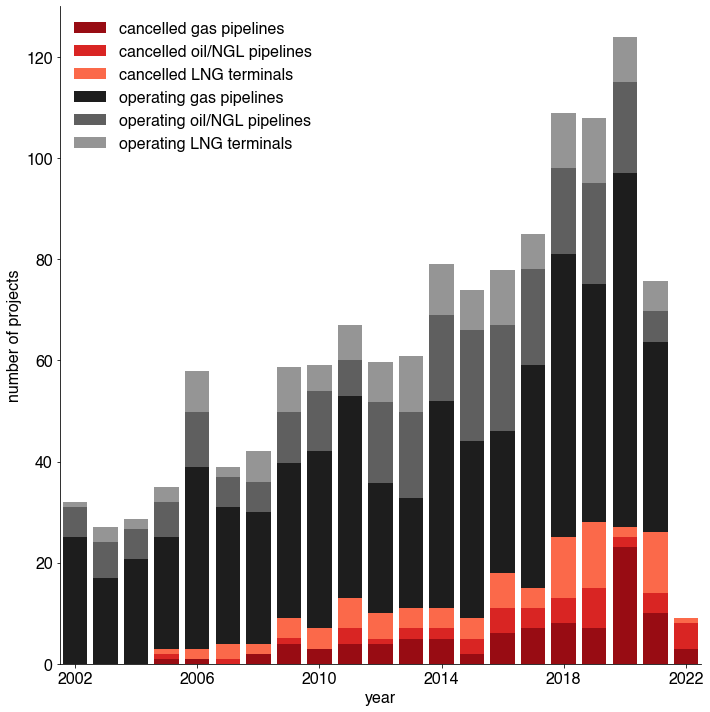

In [109]:
fig = mp.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Cancelled gas pipelines'],
      label='cancelled gas pipelines', color=red_dark)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Cancelled oil/NGL pipelines'],
      bottom=projects_df_years_sum['Cancelled gas pipelines'], label='cancelled oil/NGL pipelines',
      color=red_mid)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Cancelled LNG terminals'],
       bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines']].sum(axis=1), 
       label='cancelled LNG terminals',
       color=red_light)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Operating gas pipelines'],
      bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines', 'Cancelled LNG terminals']].sum(axis=1),
       label='operating gas pipelines',
      color=gray_dark)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Operating oil/NGL pipelines'],
      bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines', 'Cancelled LNG terminals', 'Operating gas pipelines']].sum(axis=1),
       label='operating oil/NGL pipelines',
      color=gray_mid)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Operating LNG terminals'],
       bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines', 'Cancelled LNG terminals', 'Operating gas pipelines', 'Operating oil/NGL pipelines']].sum(axis=1),
       label='operating LNG terminals',
      color=gray_light)

mp.legend(prop={'size':16}, frameon=False)

mp.tick_params(labelsize=16)
ax.set_xticks([2002,2006,2010,2014,2018,2022])
ax.set_ylabel('number of projects', fontsize=16)
ax.set_xlabel('year', fontsize=16)

ax.set_xlim(2001.5,2022.5)
ax.set_ylim(0,130)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig('GGON-cancellations-plus-operating.png', bbox_inches='tight', dpi=600, transparent=True)


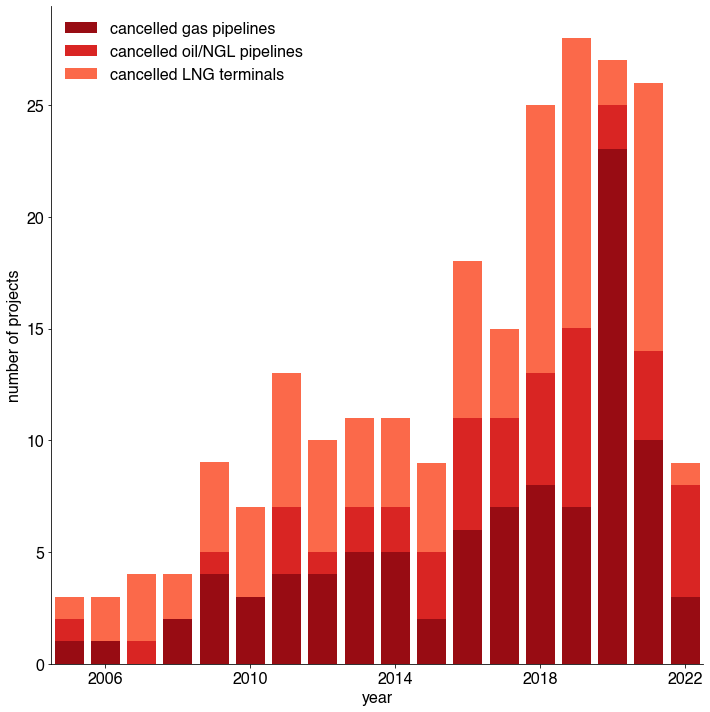

In [110]:
fig = mp.figure(figsize=(10,10))

ax = fig.add_subplot(111)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Cancelled gas pipelines'],
      label='cancelled gas pipelines', color=red_dark)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Cancelled oil/NGL pipelines'],
      bottom=projects_df_years_sum['Cancelled gas pipelines'], label='cancelled oil/NGL pipelines',
      color=red_mid)

ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Cancelled LNG terminals'],
       bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines']].sum(axis=1), 
       label='cancelled LNG terminals',
       color=red_light)

# ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Operating gas pipelines'],
#       bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines', 'Cancelled LNG terminals']].sum(axis=1),
#        label='operating gas pipelines',
#       color=gray_dark)

# ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Operating oil/NGL pipelines'],
#       bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines', 'Cancelled LNG terminals', 'Operating gas pipelines']].sum(axis=1),
#        label='operating oil/NGL pipelines',
#       color=gray_mid)

# ax.bar(x=projects_df_years_sum.index, height=projects_df_years_sum['Operating LNG terminals'],
#        bottom=projects_df_years_sum[['Cancelled gas pipelines','Cancelled oil/NGL pipelines', 'Cancelled LNG terminals', 'Operating gas pipelines', 'Operating oil/NGL pipelines']].sum(axis=1),
#        label='operating LNG terminals',
#       color=gray_light)

mp.legend(prop={'size':16}, frameon=False)

mp.tick_params(labelsize=16)
ax.set_xticks([2002,2006,2010,2014,2018,2022])
ax.set_ylabel('number of projects', fontsize=16)
ax.set_xlabel('year', fontsize=16)

ax.set_xlim(2004.5,2022.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig('GGON-cancellations-only.png', bbox_inches='tight', dpi=600, transparent=True)


In [111]:
projects_df_years_sum.replace(0,'', inplace=True)
projects_df_years_sum.to_excel('GGON-cancellations-and-operating-projects-by-year.xlsx', index_label='Year')

In [ ]:
# ****************************************
# creating figures
# ****************************************

def fig_capacity():

    terms_df_capacity_sum = pandas.DataFrame(0, index=country_list, columns=['Pre-construction','Construction'])
    terms_df_region = terms_df_orig[(terms_df_orig.Country.isin(region_df_touse.Country))&
                                    (terms_df_orig.Status.isin(['Construction','Proposed']))&
                                    (terms_df_orig.Facility.isin(['Import']))]

    # proposed
    terms_df_capacity_sum['Pre-construction'] += terms_df_region.loc[terms_df_region.Status=='Proposed'].groupby(
        'Country')['CapacityInBcm/y'].sum()
    # construction
    terms_df_capacity_sum['Construction'] += terms_df_region.loc[terms_df_region.Status=='Construction'].groupby(
        'Country')['CapacityInBcm/y'].sum()

    terms_df_capacity_sum.replace(numpy.nan,0,inplace=True)

# ****************************************
# creating figures
# ****************************************

def fig_capacity():

    terms_df_capacity_sum = pandas.DataFrame(0, index=country_list, columns=['Pre-construction','Construction'])
    terms_df_region = terms_df_orig[(terms_df_orig.Country.isin(region_df_touse.Country))&
                                    (terms_df_orig.Status.isin(['Construction','Proposed']))&
                                    (terms_df_orig.Facility.isin(['Import']))]

    # proposed
    terms_df_capacity_sum['Pre-construction'] += terms_df_region.loc[terms_df_region.Status=='Proposed'].groupby(
        'Country')['CapacityInBcm/y'].sum()
    # construction
    terms_df_capacity_sum['Construction'] += terms_df_region.loc[terms_df_region.Status=='Construction'].groupby(
        'Country')['CapacityInBcm/y'].sum()

    terms_df_capacity_sum.replace(numpy.nan,0,inplace=True)

    # reorder for descending values
    country_order = terms_df_capacity_sum.sum(axis=1).sort_values(ascending=True).index
    terms_df_capacity_sum = terms_df_capacity_sum.reindex(country_order)

    # ****************************************

    colorscale_touse = 'ylorbr'

    bar_dark = px.colors.sample_colorscale(colorscale_touse, 0.9)
    bar_light = px.colors.sample_colorscale(colorscale_touse, 0.6)

    nbars = terms_df_capacity_sum.index.size

    fig = px.bar(terms_df_capacity_sum[['Construction','Pre-construction']], 
                 color_discrete_sequence=bar_dark+bar_light, 
                 orientation='h', height=800,
                 title='Capacity of planned LNG terminals')

    fig.update_layout(
        font_family='Helvetica',
        font_color=px.colors.sample_colorscale('greys', 0.5)[0],
        bargap=0.25,
        plot_bgcolor='white',
        paper_bgcolor='white',

        yaxis_title='country',
        xaxis_title='bcm/y',
        xaxis={'side':'top'},
        title_y=.97,
        title_yanchor='top',

        legend_title='Click to toggle on/off',
        #legend=dict(yanchor="bottom",y=0.01,xanchor="right",x=0.99,bgcolor='rgba(0,0,0,0)'),
        legend=dict(yanchor="top",y=1,xanchor="left",x=1.01,bgcolor='rgba(0,0,0,0)'),
    )

    fig.update_yaxes(
        dtick=1
    )

    fig.update_xaxes(
        gridcolor=px.colors.sample_colorscale('greys', 0.25)[0]
    )
    
    return(fig, terms_df_capacity_sum)

def fig_length():

    pipes_df_length_sum = pandas.DataFrame(0, index=country_list, columns=['Pre-construction','Construction'])
    country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                                                 (country_ratios_df.Status.isin(['Construction','Proposed']))]
    
    country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                                (country_ratios_df.Status.isin(['Construction','Proposed']))]
    
    # proposed
    pipes_df_length_sum['Pre-construction'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Proposed'].groupby(
        'Country')['MergedKmByCountry'].sum()
    # construction
    pipes_df_length_sum['Construction'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Construction'].groupby(
        'Country')['MergedKmByCountry'].sum()

    pipes_df_length_sum.replace(numpy.nan,0,inplace=True)

    # reorder for descending values
    country_order = pipes_df_length_sum.sum(axis=1).sort_values(ascending=True).index
    pipes_df_length_sum = pipes_df_length_sum.reindex(country_order)

    
    # ****************************************

    colorscale_touse = 'greens'

    bar_dark = px.colors.sample_colorscale(colorscale_touse, 0.9)
    bar_light = px.colors.sample_colorscale(colorscale_touse, 0.6)

    nbars = pipes_df_length_sum.index.size

    fig = px.bar(pipes_df_length_sum[['Construction','Pre-construction']], 
                 color_discrete_sequence=bar_dark+bar_light, 
                 orientation='h', height=800,
                 title='Kilometers of planned gas pipelines')

    fig.update_layout(
        font_family='Helvetica',
        font_color=px.colors.sample_colorscale('greys', 0.5)[0],
        bargap=0.25, 
        plot_bgcolor='white',
        paper_bgcolor='white',

        yaxis_title='country',
        xaxis_title='km',
        xaxis={'side':'top'},
        title_y=.97,
        title_yanchor='top',

        legend_title='Click to toggle on/off',
        #legend=dict(yanchor="bottom",y=0.01,xanchor="right",x=0.99,bgcolor='rgba(0,0,0,0)'),
        legend=dict(yanchor="top",y=1,xanchor="left",x=1.01,bgcolor='rgba(0,0,0,0)'),
    )

    fig.update_yaxes(
        dtick=1
    )

    fig.update_xaxes(
        gridcolor=px.colors.sample_colorscale('greys', 0.25)[0]
    )
    
    return(fig, pipes_df_length_sum)

def fig_fid():
    
    terms_df_region = terms_df_orig[(terms_df_orig.Country.isin(region_df_touse.Country))&
                                    (terms_df_orig.Status.isin(['Construction','Proposed']))&
                                    (terms_df_orig.Facility.isin(['Import']))]
    country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                                (country_ratios_df.Status.isin(['Construction','Proposed']))]

    projects_df_fid_sum = pandas.DataFrame(0, index=country_list, columns=['Pipelines FID','Terminals FID','Pipelines pre-FID','Terminals pre-FID'])

    # Pipelines
    projects_df_fid_sum['Pipelines FID'] += country_ratios_df_region[country_ratios_df_region.FID.isin(['FID'])].groupby('Country')['LengthPerCountryFraction'].sum()
    projects_df_fid_sum['Pipelines pre-FID'] += country_ratios_df_region[country_ratios_df_region.FID.isin(['Pre-FID'])].groupby('Country')['LengthPerCountryFraction'].sum()
    # Terminals
    projects_df_fid_sum['Terminals FID'] += terms_df_region.loc[terms_df_region.FID.isin(['FID'])].groupby('Country')['TerminalID'].count()
    projects_df_fid_sum['Terminals pre-FID'] += terms_df_region.loc[terms_df_region.FID.isin(['Pre-FID'])].groupby('Country')['TerminalID'].count()

    projects_df_fid_sum.replace(numpy.nan,0,inplace=True)

    # reorder for descending values
    country_order = projects_df_fid_sum.sum(axis=1).sort_values(ascending=True).index
    projects_df_fid_sum = projects_df_fid_sum.reindex(country_order)

    # ****************************************

    colorscale_touse = 'blues'
    bar_pipes_dark = px.colors.sample_colorscale(colorscale_touse, 0.9)
    bar_pipes_light = px.colors.sample_colorscale(colorscale_touse, 0.6)
    colorscale_touse = 'purples'
    bar_terms_dark = px.colors.sample_colorscale(colorscale_touse, 0.9)
    bar_terms_light = px.colors.sample_colorscale(colorscale_touse, 0.6)

    nbars = projects_df_fid_sum.index.size

    fig = px.bar(projects_df_fid_sum[['Pipelines FID','Pipelines pre-FID',
                                      'Terminals FID', 'Terminals pre-FID']], 
                 color_discrete_sequence=bar_pipes_dark+bar_pipes_light+bar_terms_dark+bar_terms_light, 
                 orientation='h', height=800,
                 title='Number of projects at FID or pre-FID')

    note = '<i>Note when a pipeline passes through multiple countries, it is divided into fractions that sum to 1.</i>'
    fig.add_annotation(x=0, y=-0.1,
                       xref='x domain',
                       yref='y domain',
                       text=note,
                       showarrow=False,
                       font=dict(size=12))
    
    fig.update_layout(
        font_family='Helvetica',
        font_color=px.colors.sample_colorscale('greys', 0.5)[0],
        bargap=0.25,
        plot_bgcolor='white',
        paper_bgcolor='white',

        yaxis_title='country',
        xaxis_title='number of projects',
        xaxis={'side':'top'},
        title_y=.97,
        title_yanchor='top',

        legend_title='Click to toggle on/off',
        #legend=dict(yanchor="bottom",y=0.01,xanchor="right",x=0.99,bgcolor='rgba(0,0,0,0)'),
        legend=dict(yanchor="top",y=1,xanchor="left",x=1.01,bgcolor='rgba(0,0,0,0)'),
    )

    fig.update_yaxes(
        dtick=1
    )

    fig.update_xaxes(
        gridcolor=px.colors.sample_colorscale('greys', 0.25)[0]
    )

    return(fig, projects_df_fid_sum)

def fig_year_counts():
    
    terms_df_region = terms_df_orig[(terms_df_orig.Country.isin(region_df_touse.Country))&
                                    (terms_df_orig.Status.isin(['Cancelled', 'Operating']))&
                                    (terms_df_orig.Facility.isin(['Import']))]
    country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                                (country_ratios_df.Status.isin(['Cancelled', 'Operating']))]

    projects_df_years_sum = pandas.DataFrame(0, index=numpy.arange(1850,2023), columns=['Cancelled pipelines',
                                                                                 'Cancelled pipeline km',
                                                                                 'Cancelled terminals',
                                                                                 'Cancelled terminal capacity',
                                                                                 'Operating pipelines',
                                                                                 'Operating pipeline km',
                                                                                 'Operating terminals',
                                                                                 'Operating terminal capacity'])

    # Pipelines
    projects_df_years_sum['Cancelled pipelines'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Cancelled'].groupby('CancelledYear')['LengthPerCountryFraction'].sum()
    projects_df_years_sum['Cancelled pipeline km'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Cancelled'].groupby('CancelledYear')['MergedKmByCountry'].sum()
    # Terminals
    projects_df_years_sum['Cancelled terminals'] += terms_df_region.loc[terms_df_region.Status=='Cancelled'].groupby('CancelledYear')['TerminalID'].count()
    projects_df_years_sum['Cancelled terminal capacity'] += terms_df_region.loc[terms_df_region.Status=='Cancelled'].groupby('CancelledYear')['CapacityInBcm/y'].count()
    
    # Pipelines
    projects_df_years_sum['Operating pipelines'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Operating'].groupby('StartYearEarliest')['LengthPerCountryFraction'].sum()
    projects_df_years_sum['Operating pipeline km'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Operating'].groupby('StartYearEarliest')['MergedKmByCountry'].sum()
    # Terminals
    projects_df_years_sum['Operating terminals'] += terms_df_region.loc[terms_df_region.Status=='Operating'].groupby('StartYearEarliest')['TerminalID'].count()
    projects_df_years_sum['Operating terminal capacity'] += terms_df_region.loc[terms_df_region.Status=='Operating'].groupby('StartYearEarliest')['CapacityInBcm/y'].count()

    #projects_df_cancelled_sum.replace(numpy.nan,0,inplace=True)

    # reorder for descending values
    #country_order = projects_df_fid_sum.sum(axis=1).sort_values(ascending=True).index
    #projects_df_fid_sum = projects_df_fid_sum.reindex(country_order)

    # ****************************************

    colorscale_touse = 'reds'
    bar_pipes_cancelled = px.colors.sample_colorscale(colorscale_touse, 0.7)
    bar_terms_cancelled = px.colors.sample_colorscale(colorscale_touse, 0.4)
    colorscale_touse = 'greys'
    bar_pipes_operating = px.colors.sample_colorscale(colorscale_touse, 0.7)
    bar_terms_operating = px.colors.sample_colorscale(colorscale_touse, 0.4)

    fig = px.bar(projects_df_years_sum[['Cancelled pipelines',
                                        'Cancelled terminals',
                                        'Operating pipelines',
                                        'Operating terminals']], 
                 color_discrete_sequence=bar_pipes_cancelled+bar_terms_cancelled+bar_pipes_operating+bar_terms_operating, 
                 height=800,
                 title='Number of projects cancelled or operating')

    note = '<i>Note when a pipeline passes through multiple countries, it is divided into fractions that sum to 1.</i>'
    fig.add_annotation(x=0, y=-0.1,
                       xref='x domain',
                       yref='y domain',
                       text=note,
                       showarrow=False,
                       font=dict(size=12))
    
    fig.update_layout(
        font_family='Helvetica',
        font_color=px.colors.sample_colorscale('greys', 0.5)[0],
        bargap=0.25,
        plot_bgcolor='white',
        paper_bgcolor='white',

        yaxis_title='number of projects',
        xaxis_title='year',
        xaxis={'mirror':'allticks','side':'top'},
        title_y=.97,
        title_yanchor='top',
        xaxis_range=[2011.5,2021.5],

        legend_title='Click to toggle on/off',
        #legend=dict(yanchor="bottom",y=0.01,xanchor="right",x=0.99,bgcolor='rgba(0,0,0,0)'),
        legend=dict(yanchor="top",y=1,xanchor="left",x=1.01,bgcolor='rgba(0,0,0,0)'),
    )

    fig.update_yaxes(
        dtick=1
    )

    fig.update_xaxes(
        gridcolor=px.colors.sample_colorscale('greys', 0.25)[0]
    )

    return(fig, projects_df_years_sum)

def fig_capacity_map():

    terms_df_capacity_sum = pandas.DataFrame(0, index=country_list, columns=['Pre-construction','Construction'])
    terms_df_region = terms_df_orig[(terms_df_orig.Country.isin(region_df_touse.Country))&
                                    (terms_df_orig.Status.isin(['Construction','Proposed']))&
                                    (terms_df_orig.Facility.isin(['Import']))]

    # proposed
    terms_df_capacity_sum['Pre-construction'] += terms_df_region.loc[terms_df_region.Status=='Proposed'].groupby(
        'Country')['CapacityInBcm/y'].sum()
    # construction
    terms_df_capacity_sum['Construction'] += terms_df_region.loc[terms_df_region.Status=='Construction'].groupby(
        'Country')['CapacityInBcm/y'].sum()

    terms_df_capacity_sum.replace(numpy.nan,0,inplace=True)

    # create cloropleth info
    terms_df_capacity_sum['Capacity (bcm/y)'] = terms_df_capacity_sum.sum(axis=1)

    # add ISO Code for interaction with nat earth data
    terms_df_capacity_sum['ISOCode'] = ''
    for idx,row in terms_df_capacity_sum.iterrows():
        terms_df_capacity_sum.loc[idx,'ISOCode'] = region_df_orig.loc[region_df_orig['Country']==row.name,'ISOCode'].values

    # reorder for descending values
    country_order = terms_df_capacity_sum.sum(axis=1).sort_values(ascending=True).index
    terms_df_capacity_sum = terms_df_capacity_sum.reindex(country_order)

    fig = px.choropleth(terms_df_capacity_sum, 
                        locations=terms_df_capacity_sum['ISOCode'],
                        color='Capacity (bcm/y)', color_continuous_scale=px.colors.sequential.Oranges)#,
                        #title='Capacity of planned LNG terminals')
    
    note = 'Capacity totals mapped'
    fig.add_annotation(x=0.5, y=1.1,
                       xref='x domain',
                       yref='y domain',
                       text=note,
                       showarrow=False,
                       align='center',
                       font=dict(size=16))

    fig.update_geos(
        resolution=50,
        showcoastlines=False,
        #showcountries=True,
        #coastlinecolor=px.colors.sample_colorscale('greys', 0.9)[0],
        landcolor=px.colors.sample_colorscale('greys', 1e-5)[0],

        showocean=True,
        oceancolor=px.colors.sample_colorscale('blues', 0.05)[0],

        projection_type='azimuthal equal area',
        center=dict(lat=50, lon=7),
        projection_rotation=dict(lon=30),
        projection_scale=5.5)
    
    fig.update_layout(
        font_family='Helvetica',
        font_color=px.colors.sample_colorscale('greys', 0.5)[0],
        plot_bgcolor='white',
        paper_bgcolor='white',

        yaxis_title='country',
        xaxis_title='bcm/y',
        #title_y=.97,
        title_yanchor='top',
        dragmode=False,

        coloraxis_colorbar_x=1.01)
    
    fig.update_traces(
        colorbar=dict(thickness=100),
        selector=dict(type='choropleth'))
        #colorbar_thickness=10,
        #colorbar_thicknessmode='fraction',
        #selector=dict(type='choropleth'))
    
    return(fig)

def fig_kilometers_map():


    pipes_df_length_sum = pandas.DataFrame(0, index=country_list, columns=['Pre-construction','Construction'])
    country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                                                 (country_ratios_df.Status.isin(['Construction','Proposed']))]

    country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                                (country_ratios_df.Status.isin(['Construction','Proposed']))]

    # proposed
    pipes_df_length_sum['Pre-construction'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Proposed'].groupby(
        'Country')['MergedKmByCountry'].sum()
    # construction
    pipes_df_length_sum['Construction'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Construction'].groupby(
        'Country')['MergedKmByCountry'].sum()

    pipes_df_length_sum.replace(numpy.nan,0,inplace=True)

    # reorder for descending values
    country_order = pipes_df_length_sum.sum(axis=1).sort_values(ascending=True).index
    pipes_df_length_sum = pipes_df_length_sum.reindex(country_order)
    
    # ****************************************

    # create cloropleth info
    pipes_df_length_sum['Pipelines (km)'] = pipes_df_length_sum.sum(axis=1)

    # add ISO Code for interaction with nat earth data
    pipes_df_length_sum['ISOCode'] = ''
    for idx,row in  pipes_df_length_sum.iterrows():
         pipes_df_length_sum.loc[idx,'ISOCode'] = region_df_orig.loc[region_df_orig['Country']==row.name,'ISOCode'].values

    # reorder for descending values
    country_order =  pipes_df_length_sum.sum(axis=1).sort_values(ascending=True).index
    pipes_df_length_sum = pipes_df_length_sum.reindex(country_order)

    fig = px.choropleth(pipes_df_length_sum, 
                        locations=pipes_df_length_sum['ISOCode'],
                        color='Pipelines (km)', color_continuous_scale=px.colors.sequential.Greens)#,
                        #title='Kilometers of planned gas pipelines')

    note = 'Kilometer totals mapped'
    fig.add_annotation(x=0.5, y=1.1,
                       xref='x domain',
                       yref='y domain',
                       text=note,
                       showarrow=False,
                       align='center',
                       font=dict(size=16))
    
    fig.update_geos(
        resolution=50,
        showcoastlines=False,
        #showcountries=True,
        #coastlinecolor=px.colors.sample_colorscale('greys', 0.9)[0],
        landcolor=px.colors.sample_colorscale('greys', 1e-5)[0],

        showocean=True,
        oceancolor=px.colors.sample_colorscale('blues', 0.05)[0],

        projection_type='azimuthal equal area',
        center=dict(lat=50, lon=7),
        projection_rotation=dict(lon=30),
        projection_scale=5.5)
    
    fig.update_layout(
        font_family='Helvetica',
        font_color=px.colors.sample_colorscale('greys', 0.5)[0],
        plot_bgcolor='white',
        paper_bgcolor='white',

        yaxis_title='country',
        xaxis_title='bcm/y',
        #title_y=.97,
        title_yanchor='top',
        dragmode=False,

        coloraxis_colorbar_x=1.01)
    
    fig.update_traces(
        colorbar=dict(thickness=100),
        selector=dict(type='choropleth'))
    
    return(fig)

# ****************************************
# dashboard details
# ****************************************

external_stylesheets = [dbc.themes.BOOTSTRAP]
#app = jupyter_dash.JupyterDash(__name__, external_stylesheets=external_stylesheets)
app = dash.Dash(__name__, external_stylesheets=external_stylesheets)
app.title = "Europe Gas Tracker dashboard"
server = app.server

# ******************************
# create graphs of charts

# dash_header = html.H2(children='Coal power dashboard')

capacity_figure = dash.dcc.Graph(id='fig_capacity_id', 
                                 config={'displayModeBar':False},
                                 figure=fig_capacity()[0])
length_figure = dash.dcc.Graph(id='fig_length_id', 
                               config={'displayModeBar':False},
                               figure=fig_length()[0])
fid_figure = dash.dcc.Graph(id='fig_fid_id', 
                               config={'displayModeBar':False},
                               figure=fig_fid()[0])
year_counts_figure = dash.dcc.Graph(id='fig_year_counts_id',
                              config={'displayModeBar':False},
                              figure=fig_year_counts()[0])
map_capacity_figure = dash.dcc.Graph(id='fig_capacity_map_id',
                                     config={'displayModeBar':False},
                                     figure=fig_capacity_map())
map_kilometers_figure = dash.dcc.Graph(id='fig_kilometers_map_id',
                                     config={'displayModeBar':False},
                                     figure=fig_kilometers_map())

# ******************************
# define layout

# note the dash.html.Div([ up top is necessary for it to work...
app.layout = dash.html.Div([
    dbc.Container(fluid=True, children=[
    dbc.Row([
        dbc.Col(capacity_figure, style={'maxHeight':'300px', 'overflow':'scroll'}, align='start'),
        dbc.Col(length_figure, style={'maxHeight':'300px', 'overflow':'scroll'}, align='start')
    ]),
    dbc.Row([
        dbc.Col(map_capacity_figure, style={'maxHeight':'800px', 'overflow':'scroll'}, align='start'),
        dbc.Col(map_kilometers_figure, style={'maxHeight':'800px', 'overflow':'scroll'}, align='start')
    ]),
    dbc.Row([
        dbc.Col(fid_figure, style={'maxHeight':'800px', 'overflow':'scroll'}, align='start'),
        dbc.Col(year_counts_figure, style={'maxHeight':'800px', 'overflow':'scroll'}, align='start')
    ]),
])
])

# style={'maxHeight':'400px', 'overflow':'scroll'} - add before align='start'

#app.run_server(mode='external')
#app.run_server(mode='inline')

#@app.callback(
#    dash.dependencies.Output('figure_capacity', 'figure'),
#    dash.dependencies.Output('figure_length', 'figure'),
#    dash.dependencies.Output('figure_fid', 'figure'))

if __name__ == '__main__':
    app.run_server()

# terms_df_capacity_sum = fig_capacity()[1]
# pipes_df_length_sum = fig_length()[1]
# projects_df_fid_sum = fig_fid()[1]
#projects_df_years_sum = fig_year_counts()[1]

# terms_df_capacity_sum.to_excel('terminals_capacity_data.xlsx')
# pipes_df_length_sum.to_excel('pipelines_length_data.xlsx')
# projects_df_fid_sum.to_excel('projects_at_fid_and_prefid.xlsx')
#projects_df_years_sum.to_excel('project_counts_by_status_and_year.xlsx')

# save for David Hoffman

In [28]:
# terms_df_capacity_sum = fig_capacity()[1]
# pipes_df_length_sum = fig_length()[1]
# projects_df_fid_sum = fig_fid()[1]
#projects_df_years_sum = fig_year_counts()[1]

# terms_df_capacity_sum.to_excel('terminals_capacity_data.xlsx')
# pipes_df_length_sum.to_excel('pipelines_length_data.xlsx')
# projects_df_fid_sum.to_excel('projects_at_fid_and_prefid.xlsx')
#projects_df_years_sum.to_excel('project_counts_by_status_and_year.xlsx')